In [1]:
import pymongo
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from matplotlib.ticker import FuncFormatter
from dotenv import dotenv_values
import pandas as pd

env_config = dotenv_values("../.env")


def custom_formatter(x, pos):
    return '{:,}'.format(int(x))

In [3]:
database_name = f"openalex_v{env_config['OPENALEX_VERSION']}"
openalex_entropy_collection = pymongo.MongoClient(env_config['Mongo_Url'])[database_name]["subject_entropy"]
openalex_entropy_collection.count_documents({})

142120

In [28]:
openalex_entropy_collection.create_index([("subject", pymongo.ASCENDING)])
subject_list = openalex_entropy_collection.distinct("subject")
dataframe_list = []
print(subject_list)

['Art', 'Biology', 'Business', 'Chemistry', 'Computer science', 'Economics', 'Engineering', 'Environmental science', 'Geography', 'Geology', 'History', 'Materials science', 'Mathematics', 'Medicine', 'Philosophy', 'Physics', 'Political science', 'Psychology', 'Sociology']


In [11]:
import collections
from functools import lru_cache

start_year, end_year = 1940,2024
year_range = [year for year in range(start_year, end_year+1)]

@lru_cache(maxsize=200)
def get_openalex_entropy_data(subject, startPercent, endPercent):
    entropy_data_map = collections.defaultdict(lambda: np.full(end_year - start_year + 1,np.nan))
    # for doc in openalex_entropy_collection.find({'startPercent':startPercent, 'endPercent':endPercent}):
    for doc in openalex_entropy_collection.find({'subject':subject, 'startPercent':startPercent, 'endPercent':endPercent, 'rankType': "current"}):
        index = doc['year'] - start_year
        if index < 0:
            continue
        if "struct" == doc['entropyType']:
            key = f"Structural Entropy"
            entropy_data_map[key][index] = doc['entropy']['entropyin']
            key = f"Normalized Structural Entropy"
            entropy_data_map[key][index] = doc['entropy']['normalizeentropyin']
            
            key = "Graph Size(Structural Entropy)"
            entropy_data_map[key][index] = doc['entropy']['nodeincount']
            
        elif  "degree" == doc['entropyType']:
            key = f"Degree Distribution Entropy"
            entropy_data_map[key][index] = doc['entropy']['entropyin']
            
            key = "Graph Size(Degree Distribution Entropy)"
            entropy_data_map[key][index] = doc['entropy']['nodecount']
            
    return entropy_data_map

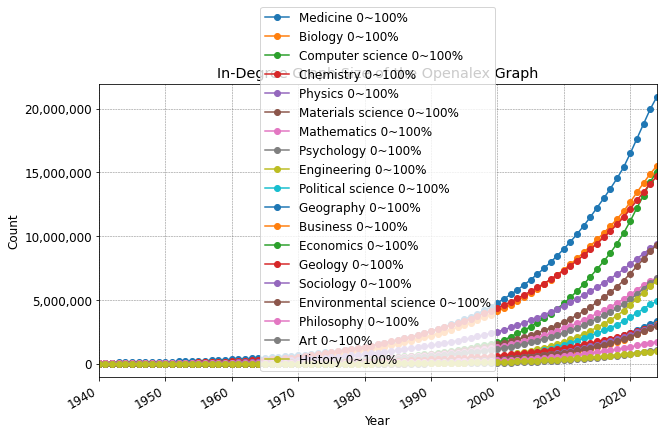

In [33]:

# OpenAlex Graph Size

plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

data = {}
start, end = (0, 100)
# for start, end in [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]:
for subject in subject_list:

    entropy_data_map = get_openalex_entropy_data(subject, start, end)
    # print(len(entropy_data_map))
    key = "Graph Size(Degree Distribution Entropy)"
    label = f"{subject} {start}~{end}%"
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o') 
    data[label] = entropy_data_map[key]
    
df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot(ax=ax1, marker='o')
dataframe_list.append((df, "Graph Size-100%"))

ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')
    
ax1.legend()
plt.title("In-Degree Graph Size of the Openalex Graph")

formatter = FuncFormatter(custom_formatter)
ax1.yaxis.set_major_formatter(formatter)

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


# In-Degree Structural Entropy of the Wikipedia Graph

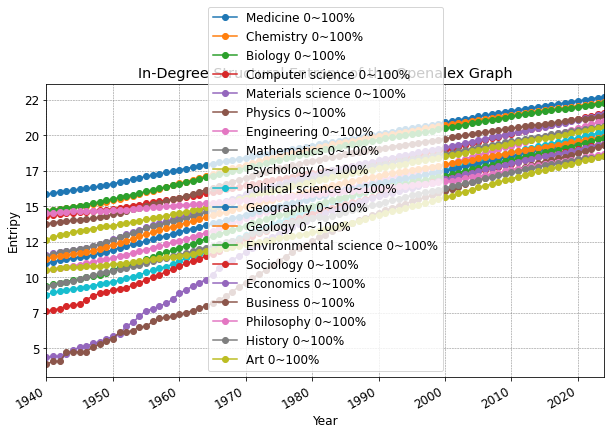

In [30]:

# In-Degree Structural Entropy of the Wikipedia Graph

plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

data = {}
start, end = (0, 100)
# for start, end in [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]:
for subject in subject_list:

    entropy_data_map = get_openalex_entropy_data(subject, start, end)
    # print(len(entropy_data_map))
    key = "Structural Entropy"
    label = f"{subject} {start}~{end}%"
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o') 
    data[label] = entropy_data_map[key]
    
df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
df.plot(ax=ax1, marker='o')
dataframe_list.append((df, "Structural-100%"))

ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title("In-Degree Structural Entropy of the Openalex Graph")

formatter = FuncFormatter(custom_formatter)
ax1.yaxis.set_major_formatter(formatter)

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


In [14]:
# # In-Degree Structural Entropy of the Wikipedia Graph

# plt.rcParams['font.size'] = 12
# fig, ax1 = plt.subplots(figsize=(10, 6))

# data = {}
# for end in [10, 20, 30, 40, 50, 60, 70, 80, 100]:
#     start = end - 10
#     entropy_data_map = get_openalex_entropy_data(start, end)
    
#     key = "Structural Entropy"
#     label=f"{key} {start}~{end}%"
#     # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o') 
#     data[label] = entropy_data_map[key]

# df = pd.DataFrame(data, index=year_range)
# df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
# dataframe_list.append((df, "Structural-2"))
# df.plot(ax=ax1, marker='o')

# ax1.set_xlim(start_year, end_year)
# # ax1.set_xticks(year_range)
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Entripy')

# ax1.legend()
# plt.title("In-Degree Structural Entropy of the OpenAlex Graph")

# formatter = FuncFormatter(custom_formatter)
# ax1.yaxis.set_major_formatter(formatter)

# plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.gcf().autofmt_xdate()
# plt.show()


In [15]:

# # In-Degree Structural Entropy of the Wikipedia Graph

# plt.rcParams['font.size'] = 12
# fig, ax1 = plt.subplots(figsize=(10, 6))

# data = {} 
# for end in [20, 40, 60, 80, 100]:
#     start = end - 20
#     entropy_data_map = get_openalex_entropy_data(start, end)
    
#     key = "Structural Entropy"
#     label=f"{key} {start}~{end}%"
#     # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o') 
#     data[label] = entropy_data_map[key]
    
# df = pd.DataFrame(data, index=year_range)
# dataframe_list.append((df, "Structural-3"))
# df.plot(ax=ax1, marker='o')


# ax1.set_xlim(start_year, end_year)
# # ax1.set_xticks(year_range)
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Entripy')
    
# ax1.legend()
# plt.title("In-Degree Structural Entropy of the OpenAlex Graph")

# formatter = FuncFormatter(custom_formatter)
# ax1.yaxis.set_major_formatter(formatter)

# plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.gcf().autofmt_xdate()
# plt.show()


# In-Degree Normalized Structural Entropy of the OpenAlex Graph

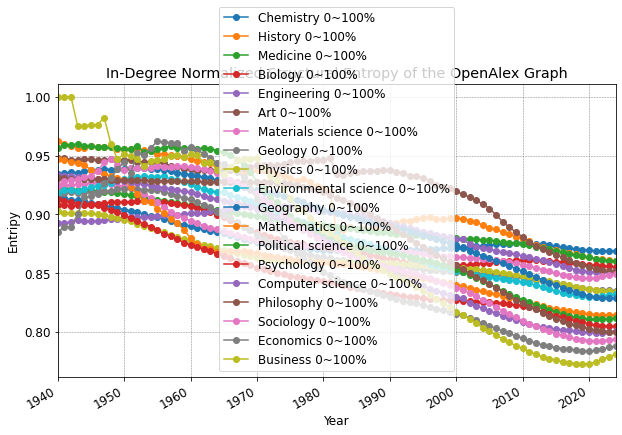

In [31]:

# In-Degree Normalized Structural Entropy of the Wikipedia Graph

plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

percent_slice = [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]
percent_slice.reverse()
data = {}


start, end = (0, 100)
# for start, end in [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]:
for subject in subject_list:
    entropy_data_map = get_openalex_entropy_data(subject, start, end)
    
    key = "Normalized Structural Entropy"
    label=f"{subject} {start}~{end}%"
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')
    data[label] = entropy_data_map[key]

df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
dataframe_list.append((df, "Normalized Structural-100%"))
df.plot(ax=ax1, marker='o')

ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title("In-Degree Normalized Structural Entropy of the OpenAlex Graph")

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


In [17]:
# # In-Degree Normalized Structural Entropy of the OpenAlex Graph

# plt.rcParams['font.size'] = 12
# fig, ax1 = plt.subplots(figsize=(10, 6))

# percent_slice = [10, 20, 30, 40, 50, 60, 70, 80, 100]
# percent_slice.reverse()
# data = {}
# for end in percent_slice:
#     start = end - 10
#     entropy_data_map = get_openalex_entropy_data(start, end)
    
#     key = "Normalized Structural Entropy"
#     label=f"{key} {start}~{end}%"
#     # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')  
#     data[label] = entropy_data_map[key]
    
# df = pd.DataFrame(data, index=year_range)
# dataframe_list.append((df, "Normalized Structural-2"))
# df.plot(ax=ax1, marker='o')

    
# ax1.set_xlim(start_year, end_year)
# # ax1.set_xticks(year_range)
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Entripy')
    
# ax1.legend()
# plt.title("In-Degree Normalized Structural Entropy of the OpenAlex Graph")

# plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.gcf().autofmt_xdate()
# plt.show()


In [18]:

# # In-Degree Normalized Structural Entropy of the OpenAlex Graph

# plt.rcParams['font.size'] = 12
# fig, ax1 = plt.subplots(figsize=(10, 6))

# percent_slice = [20, 40, 60, 80, 100]
# percent_slice.reverse()
# data = {}
# for end in percent_slice:
#     start = end - 20
#     entropy_data_map = get_openalex_entropy_data(start, end)
    
#     key = "Normalized Structural Entropy"
#     label=f"{key} {start}~{end}%"
#     # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')  
#     data[label] = entropy_data_map[key]
    
# df = pd.DataFrame(data, index=year_range)
# dataframe_list.append((df, "Normalized Structural-3"))
# df.plot(ax=ax1, marker='o')
    
# ax1.set_xlim(start_year, end_year)
# # ax1.set_xticks(year_range)
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Entripy')
    
# ax1.legend()
# plt.title("In-Degree Normalized Structural Entropy of the OpenAlex Graph")

# plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.gcf().autofmt_xdate()
# plt.show()


# In-Degree Degree Distribution Entropy of the OpenAlex Graph

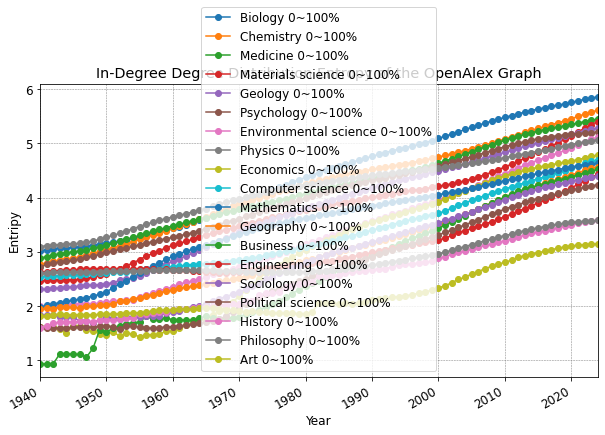

In [32]:
# In-Degree Degree Distribution Entropy of the OpenAlex Graph

plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

# percent_slice = [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]
# percent_slice.reverse()
start, end = (0, 100)
# for start, end in [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]:
data = {}
# for start, end in percent_slice:
for subject in subject_list:

    entropy_data_map = get_openalex_entropy_data(subject, start, end)
    
    key = "Degree Distribution Entropy"
    label=f"{subject} {start}~{end}%"
    # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o') 
    data[label] = entropy_data_map[key]

df = pd.DataFrame(data, index=year_range)
df = df[df.columns[df.iloc[-1].argsort()[::-1]]]
dataframe_list.append((df, "Degree Distribution-100%"))
df.plot(ax=ax1, marker='o')
    
ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title("In-Degree Degree Distribution Entropy of the OpenAlex Graph")

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


In [20]:
# # In-Degree Degree Distribution Entropy of the Wikipedia Graph

# plt.rcParams['font.size'] = 12
# fig, ax1 = plt.subplots(figsize=(10, 6))

# percent_slice = [10, 20, 30, 40, 50, 60, 70, 80, 100]
# # percent_slice.reverse()
# data = {}
# for end in percent_slice:
#     start = end - 10

#     entropy_data_map = get_openalex_entropy_data(start, end)
    
#     key = "Degree Distribution Entropy"
#     label=f"{key} {start}~{end}%"
#     # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o')  
#     data[label] = entropy_data_map[key]
    
# df = pd.DataFrame(data, index=year_range)
# dataframe_list.append((df, "Degree Distribution-2"))
# df.plot(ax=ax1, marker='o')

# ax1.set_xlim(start_year, end_year)
# # ax1.set_xticks(year_range)
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Entripy')
    
# ax1.legend()
# plt.title("In-Degree Degree Distribution Entropy of the OpenAlex Graph")

# plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.gcf().autofmt_xdate()
# plt.show()


In [21]:
# # In-Degree Degree Distribution Entropy of the OpenAlex Graph

# plt.rcParams['font.size'] = 12
# fig, ax1 = plt.subplots(figsize=(10, 6))

# percent_slice = [20, 40, 60, 80, 100]
# # percent_slice.reverse()
# data ={}
# for end in percent_slice:
#     start = end - 20

#     entropy_data_map = get_openalex_entropy_data(start, end)
    
#     key = "Degree Distribution Entropy"
#     label = f"{key} {start}~{end}%"
#     # ax1.plot(year_range, entropy_data_map[key], label=label, marker='o') 
#     data[label] = entropy_data_map[key]

# df = pd.DataFrame(data, index=year_range)
# dataframe_list.append((df, "Degree Distribution-3"))
# df.plot(ax=ax1, marker='o')    

# ax1.set_xlim(start_year, end_year)
# # ax1.set_xticks(year_range)
# ax1.set_xlabel('Year')
# ax1.set_ylabel('Entripy')
    
# ax1.legend()
# plt.title("In-Degree Degree Distribution Entropy of the OpenAlex Graph")

# plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.gcf().autofmt_xdate()
# plt.show()


In [34]:
# save df to excel

with pd.ExcelWriter('OpenAlex_Subject_Entropy.xlsx') as writer:
    for df, label in dataframe_list:
        df.to_excel(writer, sheet_name=label, index=True)
len(dataframe_list)

5

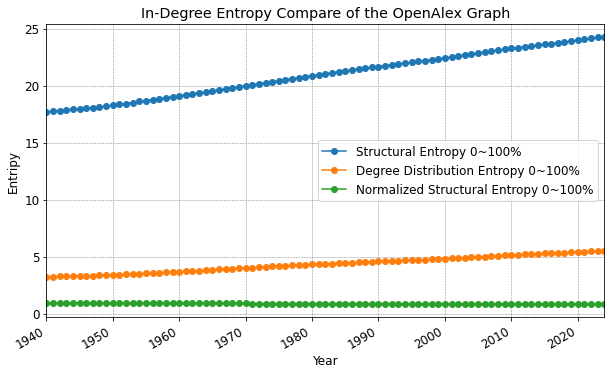

In [72]:
# compaire

# In-Degree Normalized Structural Entropy of the Wikipedia Graph

plt.rcParams['font.size'] = 12
fig, ax1 = plt.subplots(figsize=(10, 6))

# percent_slice = [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]
percent_slice = [(0,100),]
percent_slice.reverse()

for start, end in percent_slice:
    entropy_data_map = get_openalex_entropy_data(start, end)
    key = "Structural Entropy"
    ax1.plot(year_range, entropy_data_map[key], label=f"{key} {start}~{end}%", marker='o')  
    

for start, end in percent_slice:
    entropy_data_map = get_openalex_entropy_data(start, end)
    key = "Degree Distribution Entropy"
    ax1.plot(year_range, entropy_data_map[key], label=f"{key} {start}~{end}%", marker='o')  

    

for start, end in percent_slice:
    entropy_data_map = get_openalex_entropy_data(start, end)
    key = "Normalized Structural Entropy"
    ax1.plot(year_range, entropy_data_map[key], label=f"{key} {start}~{end}%", marker='o')  
    
    
ax1.set_xlim(start_year, end_year)
# ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy')
    
ax1.legend()
plt.title("In-Degree Entropy Compare of the OpenAlex Graph")

plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
plt.gcf().autofmt_xdate()
plt.show()


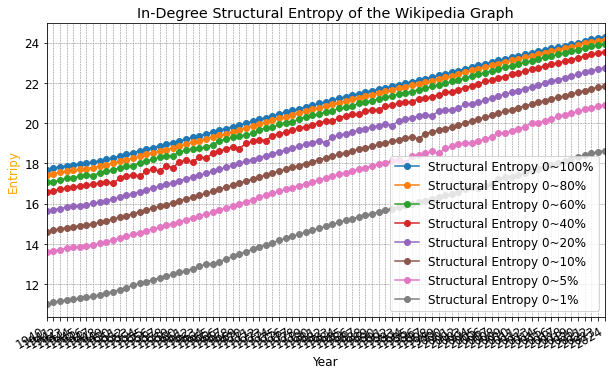

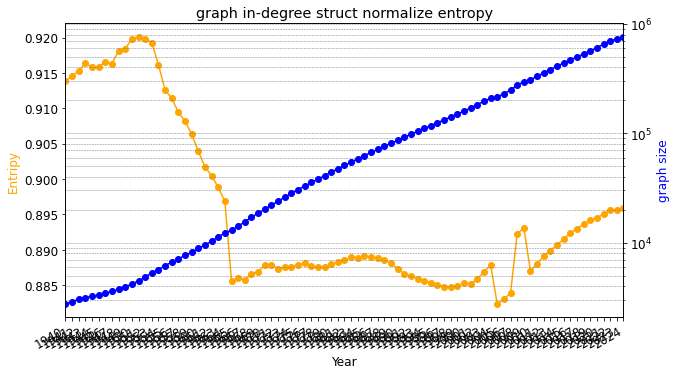

In [56]:

plt.rcParams['font.size'] = 12

fig, ax1 = plt.subplots(figsize=(10, 6))
# ax2 = ax1.twinx()
    
for start, end in [(0,100),(0,80),(0,60),(0,40),(0,20),(0,10),(0,5),(0,1)]:

    entropy_data_map = get_openalex_entropy_data(start, end)
    
    key = "Structural Entropy"
    ax1.plot(year_range, entropy_data_map[key], label=f"{key} {start}~{end}%", marker='o')  

    ax1.set_xlim(start_year, end_year)
    ax1.set_xticks(year_range)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Entripy', color='orange')

    # key= "Graph Size(Structural Entropy)"
    # ax2.plot(year_range, entropy_data_map[key], 'b-', label=f"{key} {start}~{end}%", marker='o')  # 'b-' 表示蓝色实线
    # ax2.set_ylabel('Graph Size', color='b')
    # ax2.set_yscale('log')

    # formatter = FuncFormatter(custom_formatter)
    # ax2.yaxis.set_major_formatter(formatter)
ax1.legend()
plt.title("In-Degree Structural Entropy of the Wikipedia Graph")

# 获取两个轴的图例句柄和标签
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()

# # 合并图例句柄和标签
# handles = handles1 + handles2
# labels = labels1 + labels2

# fig.legend(handles, labels, loc='lower right')
# fig.legend(handles, labels, loc='upper right')


formatter = FuncFormatter(custom_formatter)
ax1.yaxis.set_major_formatter(formatter)


plt.grid(True, axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.grid(True)
# 显示图表
plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
# 添加标题和轴标签
plt.show()

# -----------

fig, ax1 = plt.subplots(figsize=(10, 6))

key = "Normalized Structural Entropy"
ax1.plot(year_range, entropy_data_map[key],'orange',  label=key, marker='o')

# key = "degree-entropy"
# ax1.plot(year_range, entropy_data_map[key], label=key, marker='o') 

ax1.set_xlim(start_year, end_year)
ax1.set_xticks(year_range)
ax1.set_xlabel('Year')
ax1.set_ylabel('Entripy', color='orange')

ax2 = ax1.twinx()
key= "Graph Size(Structural Entropy)"
ax2.plot(year_range, entropy_data_map[key], 'b-', label=key, marker='o')  # 'b-' 表示蓝色实线
ax2.set_ylabel('graph size', color='b')
ax2.set_yscale('log')

# corr_coef, _ = pearsonr(data, np.log(entropy_data_map[node_size_key]))
# plt.title(f'{k} - pearsonr: {corr_coef:.2f}')
plt.title("graph in-degree struct normalize entropy")

# 获取两个轴的图例句柄和标签
# handles1, labels1 = ax1.get_legend_handles_labels()
# # handles2, labels2 = ax2.get_legend_handles_labels()

# # 合并图例句柄和标签
# handles = handles1 + handles2
# labels = labels1 + labels2

# # 使用fig.legend()统一添加图例
# fig.legend(handles, labels, loc='upper left')


# formatter = FuncFormatter(custom_formatter)
# ax1.yaxis.set_major_formatter(formatter)


plt.grid(True,axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
# plt.grid(True)
# 显示图表
plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
# 添加标题和轴标签
plt.show()


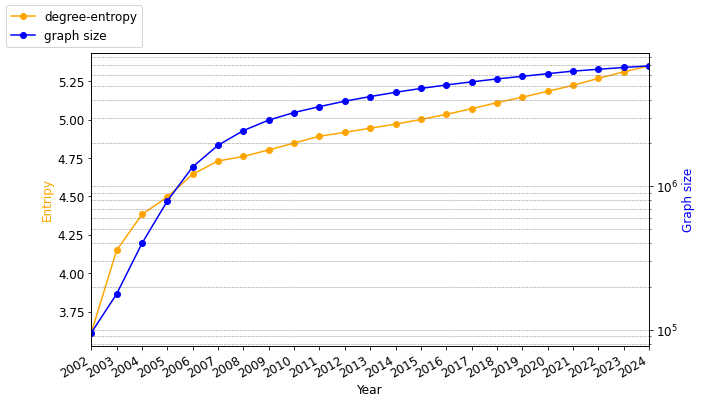

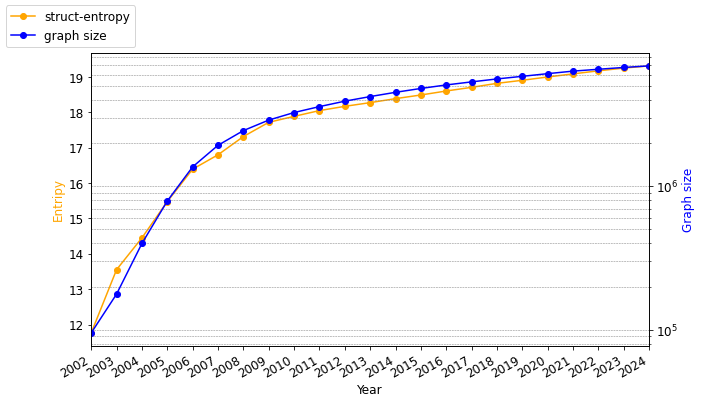

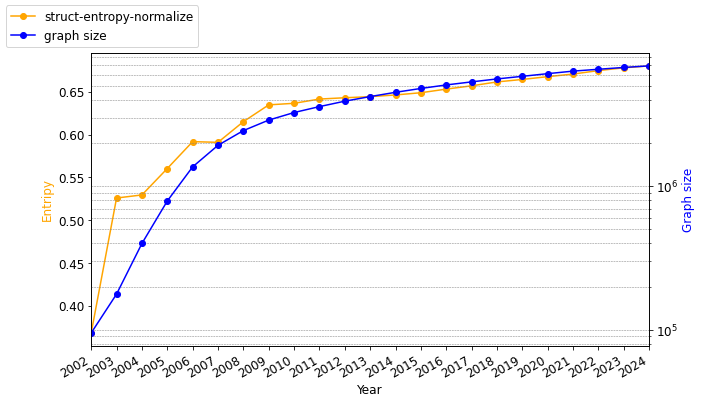

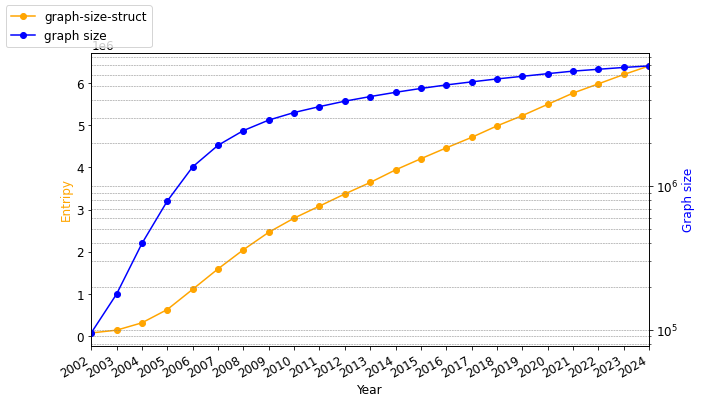

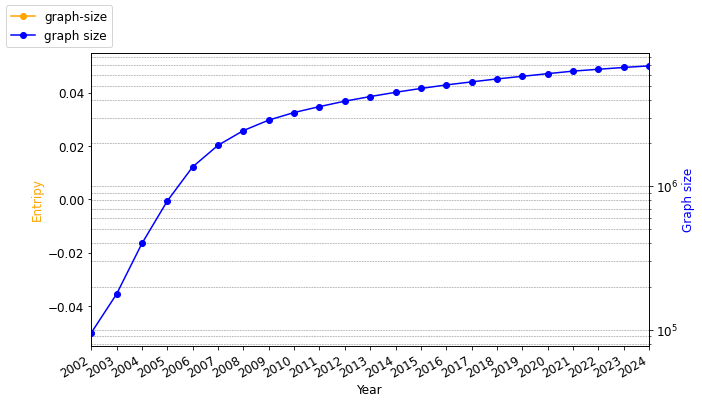

In [26]:

def custom_formatter(x, pos):
    return '{:,}'.format(int(x))

from matplotlib.ticker import FuncFormatter

year_range = [year for year in range(start_year, end_year+1)]
node_size_key = 'graph-size-degree'

plt.rcParams['font.size'] = 12

for k,data in entropy_data_map.items():
    if k == node_size_key:
        continue
    
    # plt.figure)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(year_range, data,'orange', label=k, marker='o')  # 第四条线

    ax1.set_xlim(start_year, end_year)
    ax1.set_xticks(year_range)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Entripy', color='orange')
    
    ax2 = ax1.twinx()
    ax2.plot(year_range, entropy_data_map[node_size_key], 'b-', label="graph size", marker='o')  # 'b-' 表示蓝色实线
    ax2.set_ylabel('Graph size', color='b')
    ax2.set_yscale('log')
    
    # corr_coef, _ = pearsonr(data, np.log(entropy_data_map[node_size_key]))
    # plt.title(f'{k} - pearsonr: {corr_coef:.2f}')
    # plt.title()

    # 获取两个轴的图例句柄和标签
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    # 合并图例句柄和标签
    handles = handles1 + handles2
    labels = labels1 + labels2

    # 使用fig.legend()统一添加图例
    fig.legend(handles, labels, loc='upper left')
    
    


    plt.grid(True,axis='both' , which='both', linestyle='--', linewidth=0.5, color='gray')
    # plt.grid(True)
    # 显示图表
    plt.gcf().autofmt_xdate()  # 自动旋转和调整日期标签
    # 添加标题和轴标签
    plt.show()